In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import glob
import pandas as pd
from sklearn.metrics import r2_score

In [2]:
files = sorted(glob.glob('/hurrell-scratch2/ivyglade/pdo/storm_reports/StormEvents_details-ftp_v1.0_d*.csv'))

In [3]:
# Import a single ERA5 file so that we have a lat/lon grid for reference
era5_data = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')

In [4]:
# Subset a CONUS box
era5_data_conus = era5_data['CAPE'].sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [5]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [6]:
# Standardize nino3.4
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [7]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1980-2024
pdo_1980_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1980, 2025, 1)))
nino_34_1980_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1980, 2025, 1)))

# only MAM
pdo_1980_2024_mam = pdo_1980_2024.sel(time=pdo_1980_2024.time.dt.month.isin([3, 4, 5]))
nino_34_1980_2024_mam = nino_34_1980_2024.sel(time=nino_34_1980_2024.time.dt.month.isin([3, 4, 5]))

In [8]:
# Read and concatenate in order
storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

/tmp/ipykernel_139900/3445745825.py:2: DtypeWarning: Columns (26,48) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_139900/3445745825.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_139900/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_139900/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_139900/3445745825.py:2: DtypeWarning: Columns (29,34,35,37) have mixed type

In [9]:
storm_reports['BEGIN_YEARMONTH'] = pd.to_datetime(storm_reports['BEGIN_YEARMONTH'], format='%Y%m')
storm_reports['END_YEARMONTH'] = pd.to_datetime(storm_reports['END_YEARMONTH'], format='%Y%m')

In [10]:
# Extract the month
storm_reports["MONTH"] = storm_reports["BEGIN_YEARMONTH"].dt.month

In [11]:
# Specify different storm types
tornados = storm_reports[storm_reports['EVENT_TYPE'].isin(['Tornado'])]
hail = storm_reports[storm_reports['EVENT_TYPE'].isin(['Hail'])]
tstorm_wind = storm_reports[storm_reports['EVENT_TYPE'].isin(['Thunderstorm Wind'])]

In [12]:
# Subset storm reports by time periods
tornados_mam = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tornados_mar = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3])]
tornados_apr = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([4])]
tornados_may = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([5])]

hail_mam = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
hail_mar = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3])]
hail_apr = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([4])]
hail_may = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([5])]

tstorm_wind_mam = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tstorm_wind_mar = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3])]
tstorm_wind_apr = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([4])]
tstorm_wind_may = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([5])]

In [13]:
# Want to mess around with grid size a little bit to see if we can get a more coherent signal
lat_edges = np.append(era5_data_conus['latitude'].values-0.25, 23.5)
lon_edges = np.append(era5_data_conus['longitude'].values-0.25, 294)

lat_edges_0_5deg = lat_edges[::2]
lon_edges_0_5deg = lon_edges[::2]

In [14]:
tornado_counts_mam_separated = np.zeros((135, 50, 118))
for i in range(45):
    tornado_yr_mar = tornados_mar.loc[tornados_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tornado_yr_apr = tornados_apr.loc[tornados_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tornado_yr_may = tornados_may.loc[tornados_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tornado_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tornado_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tornado_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tornado_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tornado_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tornado_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [15]:
hail_counts_mam_separated = np.zeros((135, 50, 118))

for i in range(45):
    hail_yr_mar = hail_mar.loc[hail_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    hail_yr_apr = hail_apr.loc[hail_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    hail_yr_may = hail_may.loc[hail_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    hail_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(hail_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    hail_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(hail_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    hail_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(hail_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [16]:
tstorm_wind_counts_mam_separated = np.zeros((135, 50, 118))

for i in range(45):
    tstorm_wind_yr_mar = tstorm_wind_mar.loc[tstorm_wind_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tstorm_wind_yr_apr = tstorm_wind_apr.loc[tstorm_wind_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tstorm_wind_yr_may = tstorm_wind_may.loc[tstorm_wind_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tstorm_wind_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tstorm_wind_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tstorm_wind_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tstorm_wind_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tstorm_wind_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tstorm_wind_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [21]:
len(lon_edges_0_5deg)

119

In [22]:
lat_len = 50
lon_len = 118

In [23]:
hail_coef      = np.full((lat_len, lon_len, 2), np.nan)
hail_intercept = np.full((lat_len, lon_len), np.nan)
hail_r2_partial = np.full((lat_len, lon_len, 2), np.nan)  # for partial R²

model = LinearRegression()

for i in range(lat_len):
    for j in range(lon_len):
        PDO = pdo_1980_2024_mam.values
        Nino = nino_34_1980_2024_mam.values
        hail = hail_counts_mam_separated[:, i, j]

        X_full = np.column_stack([PDO, Nino])

        valid = ~np.isnan(X_full).any(axis=1) & ~np.isnan(hail)

        if np.sum(valid) >= 3:
            X_valid = X_full[valid]
            y_valid = hail[valid]

            # Fit full model
            model.fit(X_valid, y_valid)
            y_pred_full = model.predict(X_valid)
            r2_full = r2_score(y_valid, y_pred_full)

            hail_coef[i, j, :] = model.coef_
            hail_intercept[i, j] = model.intercept_

            # Partial R² for PDO (remove PDO, use only Nino)
            model.fit(X_valid[:, [1]], y_valid)
            y_pred_nino_only = model.predict(X_valid[:, [1]])
            r2_nino_only = r2_score(y_valid, y_pred_nino_only)
            hail_r2_partial[i, j, 1] = r2_full - r2_nino_only

            # Partial R² for Nino (remove Nino, use only PDO)
            model.fit(X_valid[:, [0]], y_valid)
            y_pred_pdo_only = model.predict(X_valid[:, [0]])
            r2_pdo_only = r2_score(y_valid, y_pred_pdo_only)
            hail_r2_partial[i, j, 0] = r2_full - r2_pdo_only

    print(f'latitude {i+1} out of {lat_len} is complete.')


latitude 1 out of 50 is complete.
latitude 2 out of 50 is complete.
latitude 3 out of 50 is complete.
latitude 4 out of 50 is complete.
latitude 5 out of 50 is complete.
latitude 6 out of 50 is complete.
latitude 7 out of 50 is complete.
latitude 8 out of 50 is complete.
latitude 9 out of 50 is complete.
latitude 10 out of 50 is complete.
latitude 11 out of 50 is complete.
latitude 12 out of 50 is complete.
latitude 13 out of 50 is complete.
latitude 14 out of 50 is complete.
latitude 15 out of 50 is complete.
latitude 16 out of 50 is complete.
latitude 17 out of 50 is complete.
latitude 18 out of 50 is complete.
latitude 19 out of 50 is complete.
latitude 20 out of 50 is complete.
latitude 21 out of 50 is complete.
latitude 22 out of 50 is complete.
latitude 23 out of 50 is complete.
latitude 24 out of 50 is complete.
latitude 25 out of 50 is complete.
latitude 26 out of 50 is complete.
latitude 27 out of 50 is complete.
latitude 28 out of 50 is complete.
latitude 29 out of 50 is comp

In [24]:
tornado_coef      = np.full((lat_len, lon_len, 2), np.nan)
tornado_intercept = np.full((lat_len, lon_len), np.nan)
tornado_r2_partial = np.full((lat_len, lon_len, 2), np.nan)

model = LinearRegression()

for i in range(lat_len):
    for j in range(lon_len):
        PDO = pdo_1980_2024_mam.values
        Nino = nino_34_1980_2024_mam.values
        tornado = tornado_counts_mam_separated[:, i, j]

        X_full = np.column_stack([PDO, Nino])

        valid = ~np.isnan(X_full).any(axis=1) & ~np.isnan(tornado)

        if np.sum(valid) >= 3:
            X_valid = X_full[valid]
            y_valid = tornado[valid]

            # Fit full model
            model.fit(X_valid, y_valid)
            y_pred_full = model.predict(X_valid)
            r2_full = r2_score(y_valid, y_pred_full)

            tornado_coef[i, j, :] = model.coef_
            tornado_intercept[i, j] = model.intercept_

            # Partial R² for PDO (remove PDO, use only Nino)
            model.fit(X_valid[:, [1]], y_valid)
            y_pred_nino_only = model.predict(X_valid[:, [1]])
            r2_nino_only = r2_score(y_valid, y_pred_nino_only)
            tornado_r2_partial[i, j, 1] = r2_full - r2_nino_only

            # Partial R² for Nino (remove Nino, use only PDO)
            model.fit(X_valid[:, [0]], y_valid)
            y_pred_pdo_only = model.predict(X_valid[:, [0]])
            r2_pdo_only = r2_score(y_valid, y_pred_pdo_only)
            tornado_r2_partial[i, j, 0] = r2_full - r2_pdo_only

    print(f'latitude {i+1} out of {lat_len} is complete.')


latitude 1 out of 50 is complete.
latitude 2 out of 50 is complete.
latitude 3 out of 50 is complete.
latitude 4 out of 50 is complete.
latitude 5 out of 50 is complete.
latitude 6 out of 50 is complete.
latitude 7 out of 50 is complete.
latitude 8 out of 50 is complete.
latitude 9 out of 50 is complete.
latitude 10 out of 50 is complete.
latitude 11 out of 50 is complete.
latitude 12 out of 50 is complete.
latitude 13 out of 50 is complete.
latitude 14 out of 50 is complete.
latitude 15 out of 50 is complete.
latitude 16 out of 50 is complete.
latitude 17 out of 50 is complete.
latitude 18 out of 50 is complete.
latitude 19 out of 50 is complete.
latitude 20 out of 50 is complete.
latitude 21 out of 50 is complete.
latitude 22 out of 50 is complete.
latitude 23 out of 50 is complete.
latitude 24 out of 50 is complete.
latitude 25 out of 50 is complete.
latitude 26 out of 50 is complete.
latitude 27 out of 50 is complete.
latitude 28 out of 50 is complete.
latitude 29 out of 50 is comp

In [25]:
tstorm_wind_coef      = np.full((lat_len, lon_len, 2), np.nan)
tstorm_wind_intercept = np.full((lat_len, lon_len), np.nan)
tstorm_wind_r2_partial = np.full((lat_len, lon_len, 2), np.nan)

model = LinearRegression()

for i in range(lat_len):
    for j in range(lon_len):
        PDO = pdo_1980_2024_mam.values
        Nino = nino_34_1980_2024_mam.values
        tstorm_wind = tstorm_wind_counts_mam_separated[:, i, j]

        X_full = np.column_stack([PDO, Nino])

        valid = ~np.isnan(X_full).any(axis=1) & ~np.isnan(tstorm_wind)

        if np.sum(valid) >= 3:
            X_valid = X_full[valid]
            y_valid = tstorm_wind[valid]

            # Fit full model
            model.fit(X_valid, y_valid)
            y_pred_full = model.predict(X_valid)
            r2_full = r2_score(y_valid, y_pred_full)

            tstorm_wind_coef[i, j, :] = model.coef_
            tstorm_wind_intercept[i, j] = model.intercept_

            # Partial R² for PDO (remove PDO, use only Nino)
            model.fit(X_valid[:, [1]], y_valid)
            y_pred_nino_only = model.predict(X_valid[:, [1]])
            r2_nino_only = r2_score(y_valid, y_pred_nino_only)
            tstorm_wind_r2_partial[i, j, 1] = r2_full - r2_nino_only

            # Partial R² for Nino (remove Nino, use only PDO)
            model.fit(X_valid[:, [0]], y_valid)
            y_pred_pdo_only = model.predict(X_valid[:, [0]])
            r2_pdo_only = r2_score(y_valid, y_pred_pdo_only)
            tstorm_wind_r2_partial[i, j, 0] = r2_full - r2_pdo_only

    print(f'latitude {i+1} out of {lat_len} is complete.')


latitude 1 out of 50 is complete.
latitude 2 out of 50 is complete.
latitude 3 out of 50 is complete.
latitude 4 out of 50 is complete.
latitude 5 out of 50 is complete.
latitude 6 out of 50 is complete.
latitude 7 out of 50 is complete.
latitude 8 out of 50 is complete.
latitude 9 out of 50 is complete.
latitude 10 out of 50 is complete.
latitude 11 out of 50 is complete.
latitude 12 out of 50 is complete.
latitude 13 out of 50 is complete.
latitude 14 out of 50 is complete.
latitude 15 out of 50 is complete.
latitude 16 out of 50 is complete.
latitude 17 out of 50 is complete.
latitude 18 out of 50 is complete.
latitude 19 out of 50 is complete.
latitude 20 out of 50 is complete.
latitude 21 out of 50 is complete.
latitude 22 out of 50 is complete.
latitude 23 out of 50 is complete.
latitude 24 out of 50 is complete.
latitude 25 out of 50 is complete.
latitude 26 out of 50 is complete.
latitude 27 out of 50 is complete.
latitude 28 out of 50 is complete.
latitude 29 out of 50 is comp

In [26]:
tornado_pdo_coef  = tornado_coef.swapaxes(0, 2).swapaxes(1, 2)[0]
tornado_nino_coef = tornado_coef.swapaxes(0, 2).swapaxes(1, 2)[1]

tstorm_wind_pdo_coef  = tstorm_wind_coef.swapaxes(0, 2).swapaxes(1, 2)[0]
tstorm_wind_nino_coef = tstorm_wind_coef.swapaxes(0, 2).swapaxes(1, 2)[1]

hail_pdo_coef  = hail_coef.swapaxes(0, 2).swapaxes(1, 2)[0]
hail_nino_coef = hail_coef.swapaxes(0, 2).swapaxes(1, 2)[1]

In [27]:
tornado_pdo_coef[tornado_pdo_coef == 0] = np.nan
tornado_nino_coef[tornado_nino_coef == 0] = np.nan

tstorm_wind_pdo_coef[tstorm_wind_pdo_coef == 0] = np.nan
tstorm_wind_nino_coef[tstorm_wind_nino_coef == 0] = np.nan

hail_pdo_coef[hail_pdo_coef == 0] = np.nan
hail_nino_coef[hail_nino_coef == 0] = np.nan

In [28]:
tornado_pdo_r_2 = tornado_r2_partial.swapaxes(0, 2).swapaxes(1, 2)[0]
tornado_nino_r_2 = tornado_r2_partial.swapaxes(0, 2).swapaxes(1, 2)[1]

tstorm_wind_pdo_r_2 = tstorm_wind_r2_partial.swapaxes(0, 2).swapaxes(1, 2)[0]
tstorm_wind_nino_r_2 = tstorm_wind_r2_partial.swapaxes(0, 2).swapaxes(1, 2)[1]

hail_pdo_r_2 = hail_r2_partial.swapaxes(0, 2).swapaxes(1, 2)[0]
hail_nino_r_2 = hail_r2_partial.swapaxes(0, 2).swapaxes(1, 2)[1]

In [29]:
# IDing when the regression slope is positive
tornado_pdo_pos_coef = np.where(tornado_pdo_coef > 0, 1, tornado_pdo_coef)
tornado_nino_pos_coef = np.where(tornado_nino_coef > 0, 1, tornado_nino_coef)

tstorm_wind_pdo_pos_coef = np.where(tstorm_wind_pdo_coef > 0, 1, tstorm_wind_pdo_coef)
tstorm_wind_nino_pos_coef = np.where(tstorm_wind_nino_coef > 0, 1, tstorm_wind_nino_coef)

hail_pdo_pos_coef = np.where(hail_pdo_coef > 0, 1, hail_pdo_coef)
hail_nino_pos_coef = np.where(hail_nino_coef > 0, 1, hail_nino_coef)

In [30]:
# IDing when the regression slope is negative
tornado_pdo_coef_sign = np.where(tornado_pdo_pos_coef < 0, -1, 1)
tornado_nino_coef_sign = np.where(tornado_nino_pos_coef < 0, -1, 1)

tstorm_wind_pdo_coef_sign = np.where(tstorm_wind_pdo_pos_coef < 0, -1, 1)
tstorm_wind_nino_coef_sign = np.where(tstorm_wind_nino_pos_coef < 0, -1, 1)

hail_pdo_coef_sign = np.where(hail_pdo_pos_coef < 0, -1, 1)
hail_nino_coef_sign = np.where(hail_nino_pos_coef < 0, -1, 1)

In [31]:
# Calculating r from r^2
tornado_pdo_r = tornado_pdo_coef_sign * np.sqrt(tornado_pdo_r_2)
tornado_nino_r = tornado_nino_coef_sign * np.sqrt(tornado_nino_r_2)

tstorm_wind_pdo_r = tstorm_wind_pdo_coef_sign * np.sqrt(tstorm_wind_pdo_r_2)
tstorm_wind_nino_r = tstorm_wind_nino_coef_sign * np.sqrt(tstorm_wind_nino_r_2)

hail_pdo_r = hail_pdo_coef_sign * np.sqrt(hail_pdo_r_2)
hail_nino_r = hail_nino_coef_sign * np.sqrt(hail_nino_r_2)

In [32]:
# Filling where r = 1 with nans because it means there were no storm reports
tornado_pdo_r[tornado_pdo_r == 1] = np.nan
tornado_nino_r[tornado_nino_r == 1] = np.nan

tstorm_wind_pdo_r[tstorm_wind_pdo_r == 1] = np.nan
tstorm_wind_nino_r[tstorm_wind_nino_r == 1] = np.nan

hail_pdo_r[hail_pdo_r == 1] = np.nan
hail_nino_r[hail_nino_r == 1] = np.nan

In [33]:
# Calculating the t-statistic
tornado_pdo_t = tornado_pdo_r * ((135-2)**0.5) / ((1-tornado_pdo_r ** 2)**0.5)
tornado_nino_t = tornado_nino_r * ((135-2)**0.5) / ((1-tornado_nino_r ** 2)**0.5)

tstorm_wind_pdo_t = tstorm_wind_pdo_r * ((135-2)**0.5) / ((1-tstorm_wind_pdo_r ** 2)**0.5)
tstorm_wind_nino_t = tstorm_wind_nino_r * ((135-2)**0.5) / ((1-tstorm_wind_nino_r ** 2)**0.5)

hail_pdo_t = hail_pdo_r * ((135-2)**0.5) / ((1-hail_pdo_r ** 2)**0.5)
hail_nino_t = hail_nino_r * ((135-2)**0.5) / ((1-hail_nino_r ** 2)**0.5)

In [34]:
# Calculating the p-values
tornado_pdo_p = 2 * (1 - scipy.stats.t.cdf(abs(tornado_pdo_t), 135-2))
tornado_nino_p = 2 * (1 - scipy.stats.t.cdf(abs(tornado_nino_t), 135-2))

tstorm_wind_pdo_p = 2 * (1 - scipy.stats.t.cdf(abs(tstorm_wind_pdo_t), 135-2))
tstorm_wind_nino_p = 2 * (1 - scipy.stats.t.cdf(abs(tstorm_wind_nino_t), 135-2))

hail_pdo_p = 2 * (1 - scipy.stats.t.cdf(abs(hail_pdo_t), 135-2))
hail_nino_p = 2 * (1 - scipy.stats.t.cdf(abs(hail_nino_t), 135-2))

In [35]:
# Calculating adjusted p-values to account for the False Discovery Rate
tornado_pdo_adj_p = pdo_functions.control_FDR(tornado_pdo_p, 50, 118)
tornado_nino_adj_p = pdo_functions.control_FDR(tornado_nino_p, 50, 118)

tstorm_wind_pdo_adj_p = pdo_functions.control_FDR(tstorm_wind_pdo_p, 50, 118)
tstorm_wind_nino_adj_p = pdo_functions.control_FDR(tstorm_wind_nino_p, 50, 118)

hail_pdo_adj_p = pdo_functions.control_FDR(hail_pdo_p, 50, 118)
hail_nino_adj_p = pdo_functions.control_FDR(hail_nino_p, 50, 118)

In [36]:
# Evaluating significance
tornado_pdo_sig = np.where(tornado_pdo_p < tornado_pdo_adj_p, 3, 0)
tornado_nino_sig = np.where(tornado_nino_p < tornado_nino_adj_p, 3, 0)

tstorm_wind_pdo_sig = np.where(tstorm_wind_pdo_p < tstorm_wind_pdo_adj_p, 3, 0)
tstorm_wind_nino_sig = np.where(tstorm_wind_nino_p < tstorm_wind_nino_adj_p, 3, 0)

hail_pdo_sig = np.where(hail_pdo_p < hail_pdo_adj_p, 3, 0)
hail_nino_sig = np.where(hail_nino_p < hail_nino_adj_p, 3, 0)

In [66]:
tornado_pdo_r[tornado_pdo_r == 0] = np.nan
tornado_nino_r[tornado_nino_r == 0] = np.nan

tstorm_wind_pdo_r[tstorm_wind_pdo_r == 0] = np.nan
tstorm_wind_nino_r[tstorm_wind_nino_r == 0] = np.nan

hail_pdo_r[hail_pdo_r == 0] = np.nan
hail_nino_r[hail_nino_r == 0] = np.nan

tornado_pdo_r_2[tornado_pdo_r_2 == 0] = np.nan
tornado_nino_r_2[tornado_nino_r_2 == 0] = np.nan

tstorm_wind_pdo_r_2[tstorm_wind_pdo_r_2 == 0] = np.nan
tstorm_wind_nino_r_2[tstorm_wind_nino_r_2 == 0] = np.nan

hail_pdo_r_2[hail_pdo_r_2 == 0] = np.nan
hail_nino_r_2[hail_nino_r_2 == 0] = np.nan

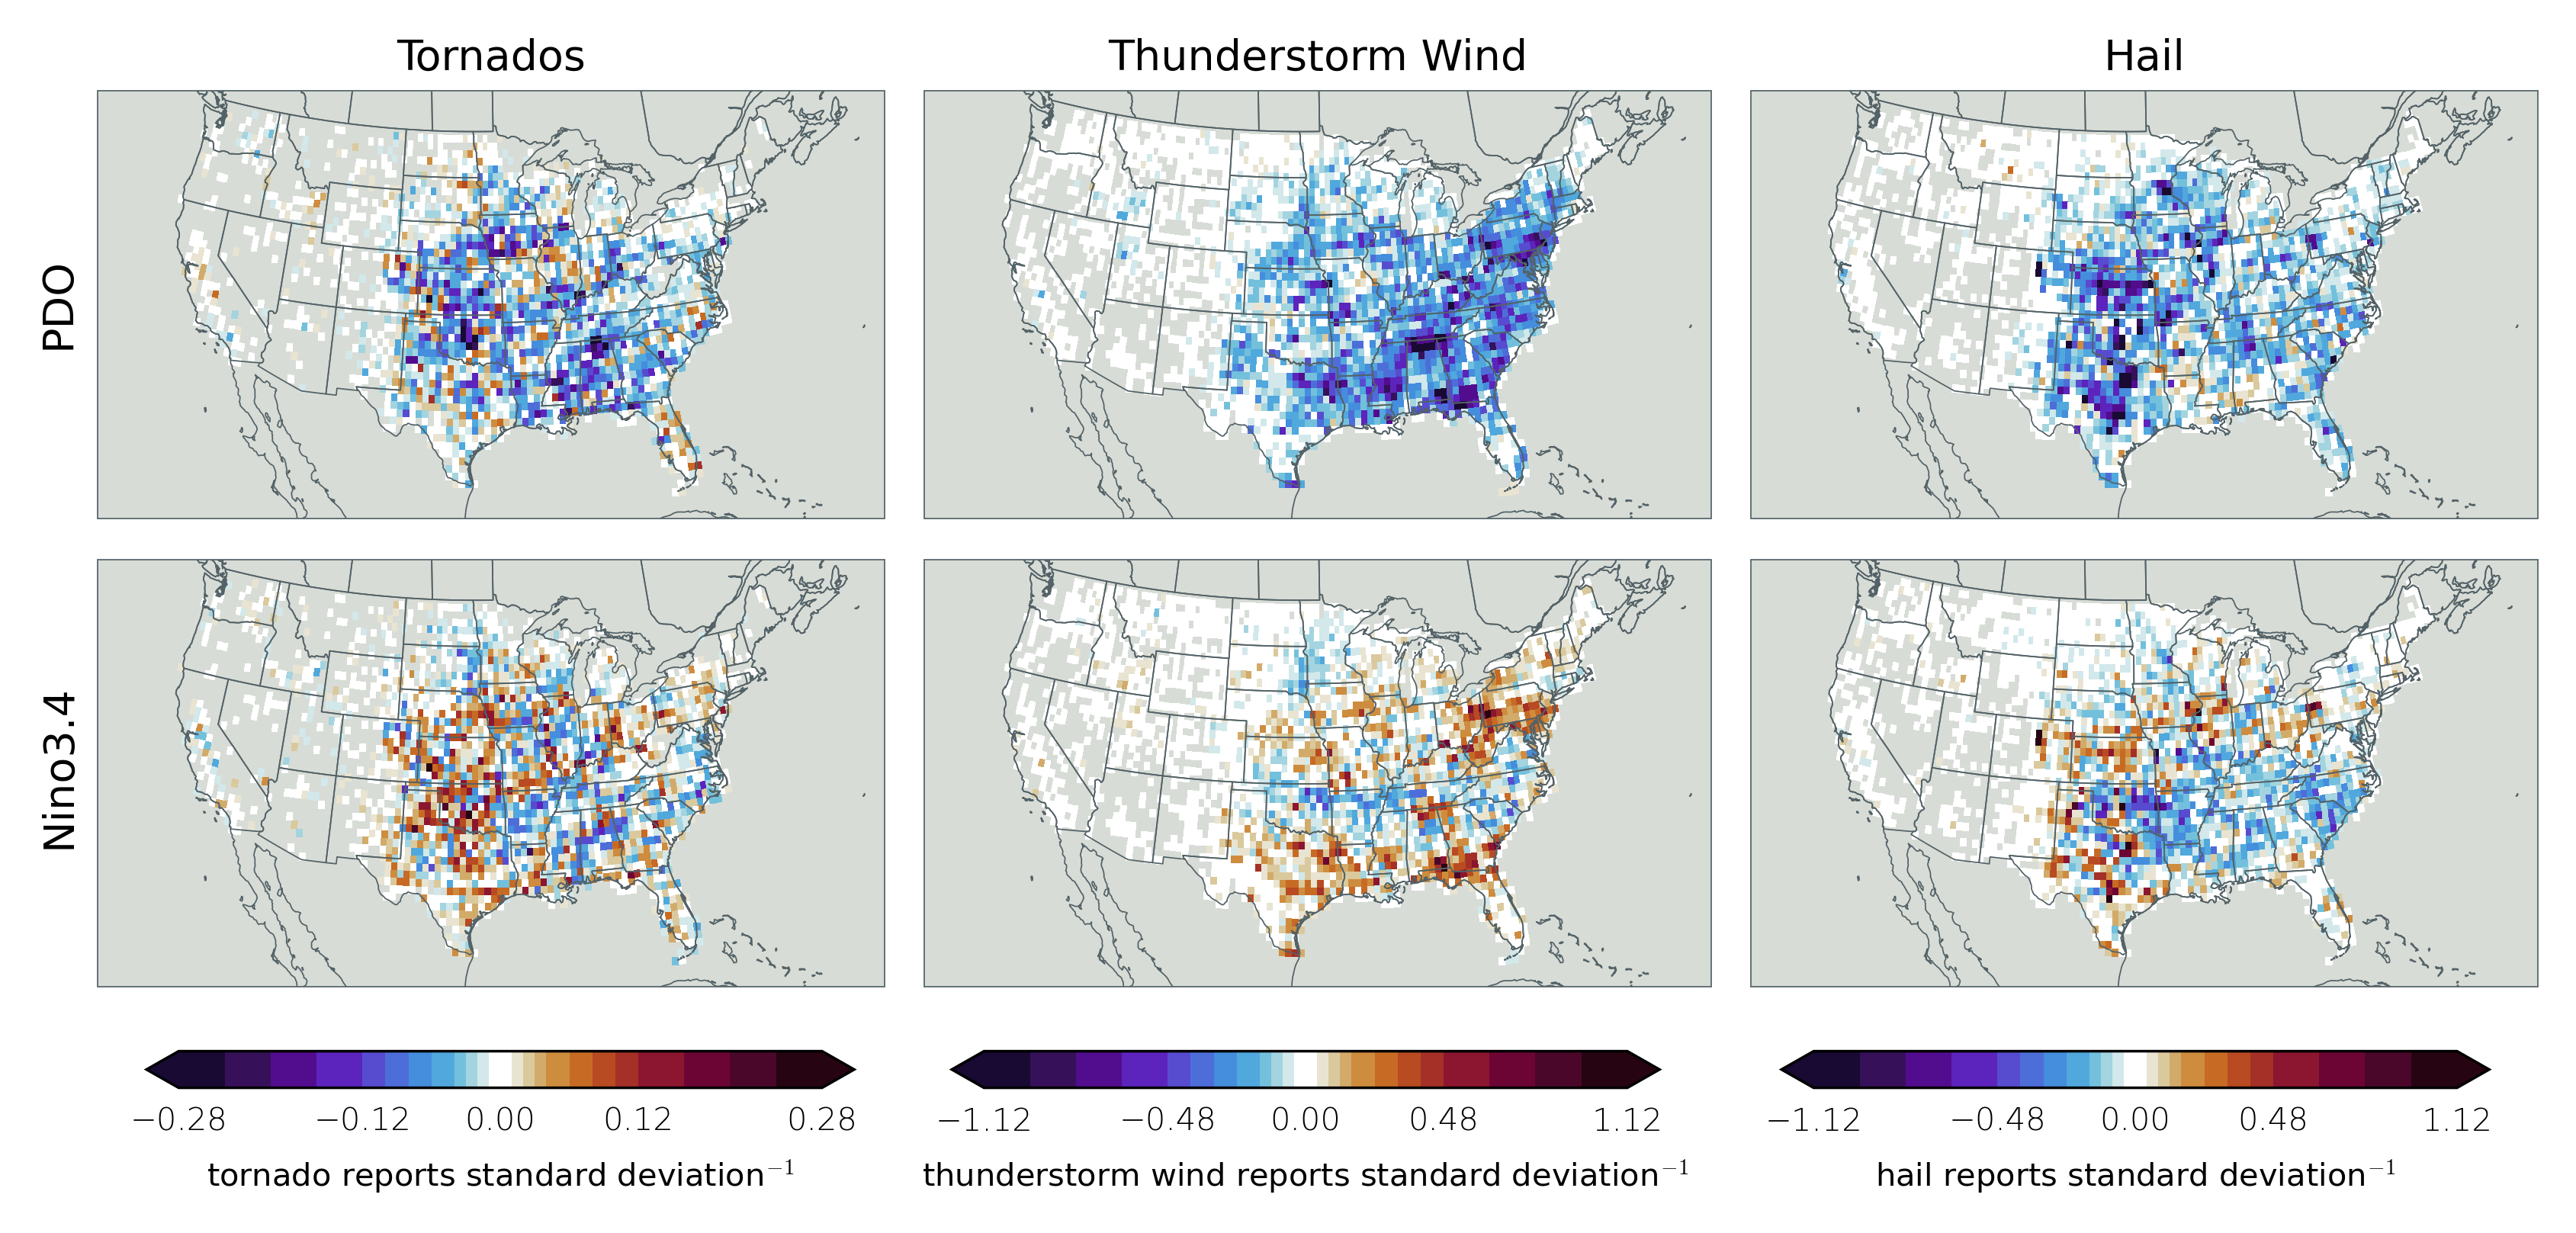

In [38]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

tornado_bounds = [-0.28, -0.24, -0.2, -0.16, -0.12, -0.1, -0.08, -0.06, -0.04, -0.03, -0.02, -0.01, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1, 0.12, 0.16, 0.2, 0.24, 0.28]
tornado_norm   = c.BoundaryNorm(tornado_bounds, plt.get_cmap('cmr.fusion_r').N)

tstorm_wind_bounds = [-1.12, -0.96, -0.8, -0.64, -0.48, -0.4, -0.32, -0.24, -0.16, -0.12, -0.08, -0.04, 0.04, 0.08, 0.12, 0.16, 0.24, 0.32, 0.4, 0.48, 0.64, 0.8, 0.96, 1.12]
tstorm_wind_norm   = c.BoundaryNorm(tstorm_wind_bounds, plt.get_cmap('cmr.fusion_r').N)

hail_bounds = [-1.12, -0.96, -0.8, -0.64, -0.48, -0.4, -0.32, -0.24, -0.16, -0.12, -0.08, -0.04, 0.04, 0.08, 0.12, 0.16, 0.24, 0.32, 0.4, 0.48, 0.64, 0.8, 0.96, 1.12]
hail_norm   = c.BoundaryNorm(hail_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tornado_pdo_coef), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tornado_nino_coef), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)

ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tstorm_wind_pdo_coef), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tstorm_wind_nino_coef), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

ax[2].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(hail_pdo_coef), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)
ax[5].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(hail_nino_coef), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)

if len(lon_edges_0_5deg) == tornado_pdo_sig.shape[1] + 1:
    lon_centers_0_5deg = 0.5 * (lon_edges_0_5deg[:-1] + lon_edges_0_5deg[1:])
if len(lat_edges_0_5deg) == tornado_pdo_sig.shape[0] + 1:
    lat_centers_0_5deg = 0.5 * (lat_edges_0_5deg[:-1] + lat_edges_0_5deg[1:])

ax[0].contourf(lon_centers_0_5deg, lat_centers_0_5deg, np.flipud(tornado_pdo_sig), transform=ccrs.PlateCarree(), hatches=[None, '\\\\\\\\\\\\\\\\\\\\\\'], colors=None, alpha=0)
ax[1].contourf(lon_centers_0_5deg, lat_centers_0_5deg, np.flipud(tstorm_wind_pdo_sig), transform=ccrs.PlateCarree(), hatches=[None, '\\\\\\\\\\\\\\\\\\\\\\'], colors=None, alpha=0)

cax = plt.axes([0.02, .2, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tornado_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', ticks=[-0.28, -0.12, 0, 0.12, 0.28])
cbar.set_label(r'tornado reports standard deviation$^{-1}$', size=6, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=6, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.35, .2, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tstorm_wind_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', ticks=[-1.12, -0.48, 0, 0.48, 1.12])
cbar2.set_label(r'thunderstorm wind reports standard deviation$^{-1}$', size=6, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=6, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.69, .2, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=hail_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', ticks=[-1.12, -0.48, 0, 0.48, 1.12])
cbar3.set_label(r'hail reports standard deviation$^{-1}$', size=6, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=6, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.5)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('Tornados', fontsize=8, pad=4)
ax[1].set_title('Thunderstorm Wind', fontsize=8, pad=4)
ax[2].set_title('Hail', fontsize=8, pad=4)

ax[0].text(-3250000, -120000, 'PDO', rotation='vertical', fontweight='normal', fontsize=8)
ax[3].text(-3250000, -350000, 'Nino3.4', rotation='vertical', fontweight='normal', fontsize=8)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

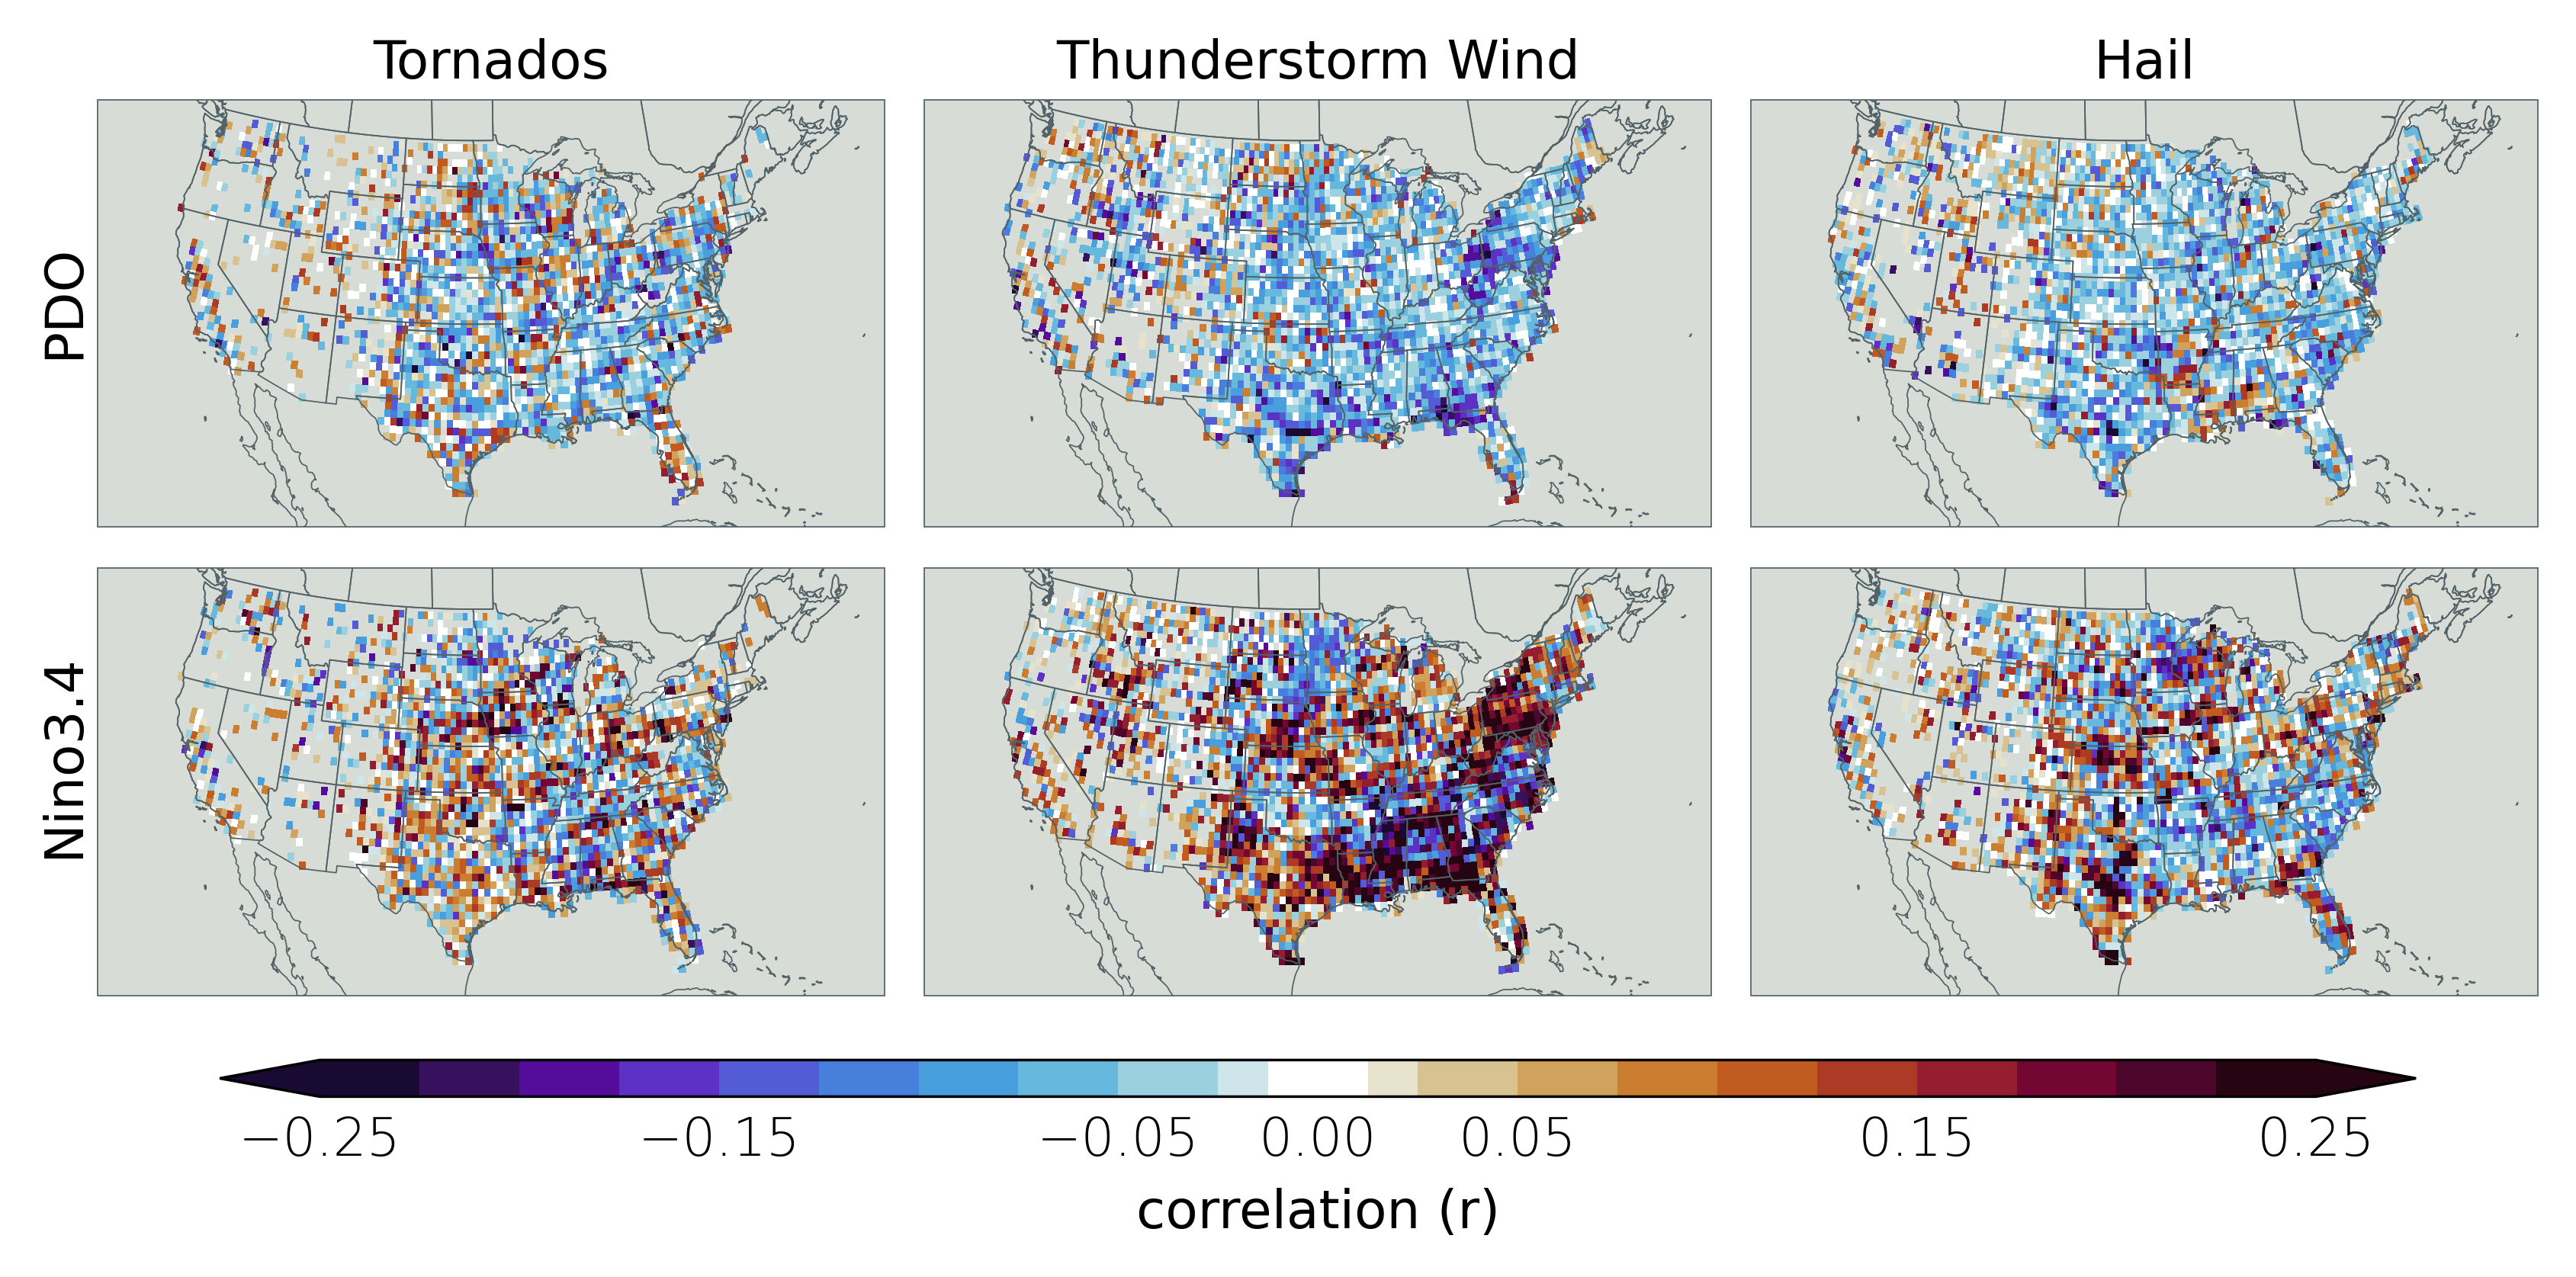

In [62]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = [-0.25, -0.225, -0.2, -0.175, -0.15, -0.125, -0.1, -0.075, -0.05, -0.025, -0.0125, 0.0125, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tornado_pdo_r), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tornado_nino_r), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tstorm_wind_pdo_r), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tstorm_wind_nino_r), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[2].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(hail_pdo_r), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[5].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(hail_nino_r), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[0].set_title('Tornados', fontsize=10, pad=4)
ax[1].set_title('Thunderstorm Wind', fontsize=10, pad=4)
ax[2].set_title('Hail', fontsize=10, pad=4)

ax[0].text(-3250000, -120000, 'PDO', rotation='vertical', fontweight='normal', fontsize=10)
ax[3].text(-3250000, -350000, 'Nino3.4', rotation='vertical', fontweight='normal', fontsize=10)

cax = plt.axes([0.05, .2, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', ticks=[-0.25, -0.15, -0.05, 0, 0.05, 0.15, 0.25])
cbar.set_label(r'correlation (r)', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

In [64]:
# full cmap
full_cmap = cmr.fusion_r

redside = c.LinearSegmentedColormap.from_list('fusion_r_red', full_cmap(np.linspace(0.5, 1, 256)))

In [80]:
hail_nino_sig.sum()

0

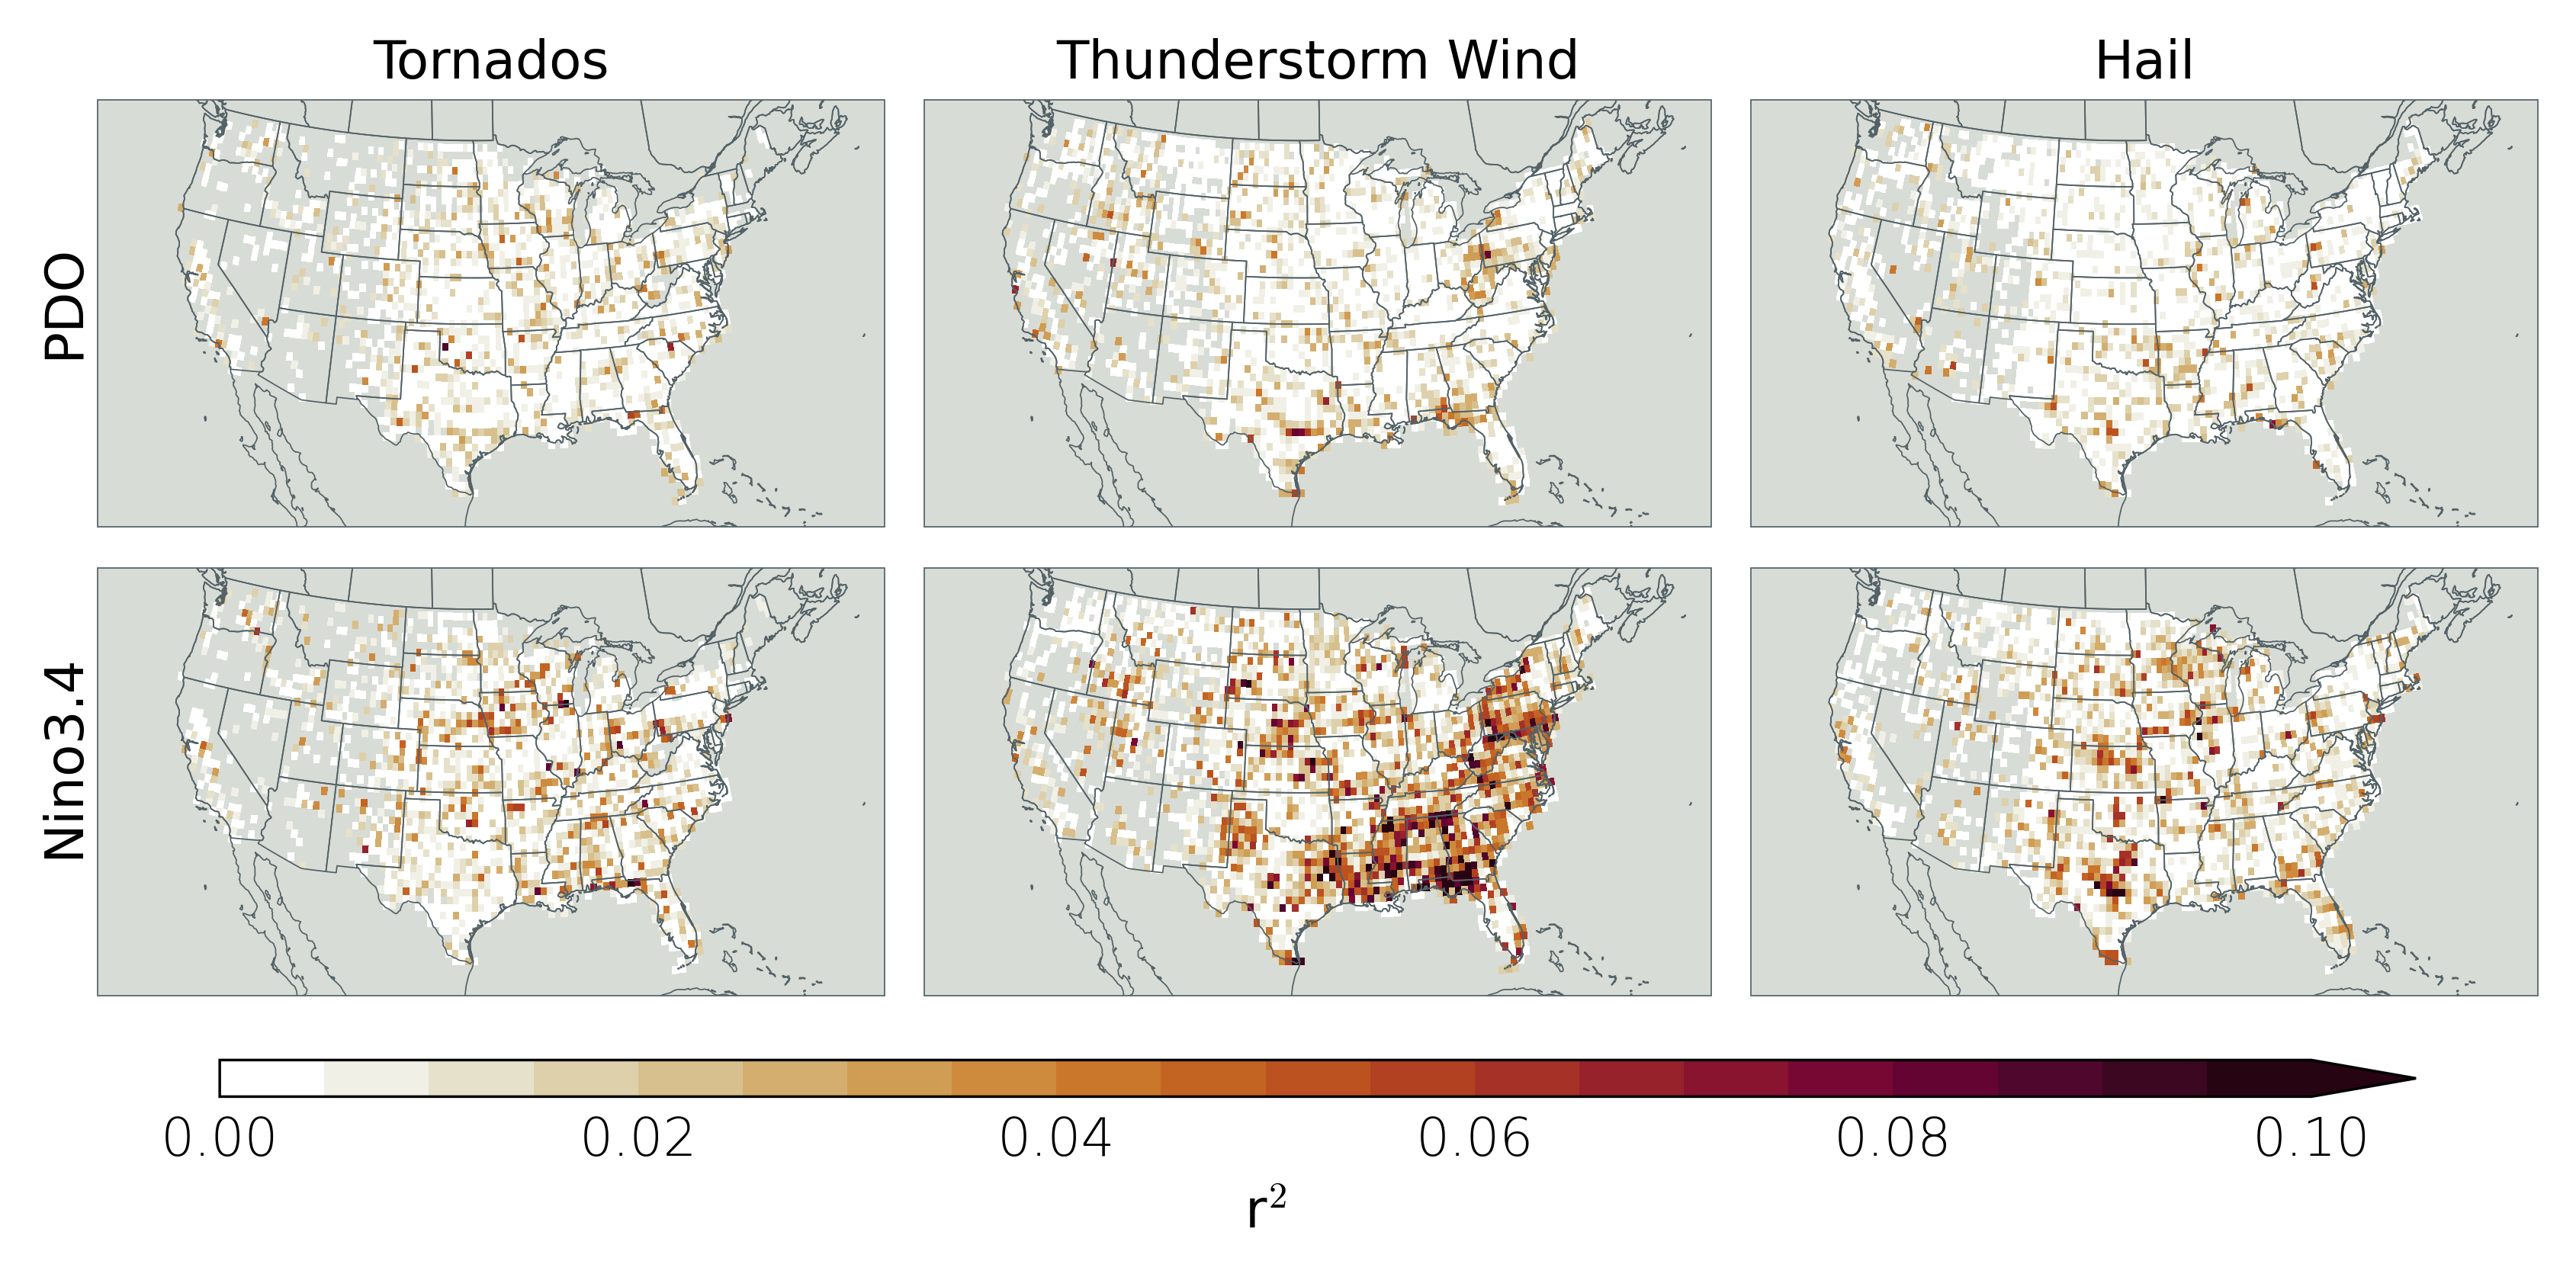

In [81]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = np.arange(0, 0.105, 0.005)

norm = c.BoundaryNorm(bounds, redside.N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tornado_pdo_r_2), transform=ccrs.PlateCarree(), shading='auto', cmap=redside, norm=norm)
ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tornado_nino_r_2), transform=ccrs.PlateCarree(), shading='auto', cmap=redside, norm=norm)

ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tstorm_wind_pdo_r_2), transform=ccrs.PlateCarree(), shading='auto', cmap=redside, norm=norm)
ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tstorm_wind_nino_r_2), transform=ccrs.PlateCarree(), shading='auto', cmap=redside, norm=norm)

ax[2].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(hail_pdo_r_2), transform=ccrs.PlateCarree(), shading='auto', cmap=redside, norm=norm)
ax[5].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(hail_nino_r_2), transform=ccrs.PlateCarree(), shading='auto', cmap=redside, norm=norm)

# ax[0].contourf(lon_edges_0_5deg, lat_edges_0_5deg, tornado_pdo_sig, transform=ccrs.PlateCarree(), hatches=[None, '\\\\\\\\\\\\\\\\\\'], colors=None, alpha=0) 
# ax[3].contourf(lon_edges_0_5deg, lat_edges_0_5deg, tornado_nino_sig, transform=ccrs.PlateCarree(), hatches=[None, '\\\\\\\\\\\\\\\\\\'], colors=None, alpha=0)

ax[0].set_title('Tornados', fontsize=10, pad=4)
ax[1].set_title('Thunderstorm Wind', fontsize=10, pad=4)
ax[2].set_title('Hail', fontsize=10, pad=4)

ax[0].text(-3250000, -120000, 'PDO', rotation='vertical', fontweight='normal', fontsize=10)
ax[3].text(-3250000, -350000, 'Nino3.4', rotation='vertical', fontweight='normal', fontsize=10)

cax = plt.axes([0.05, .2, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=redside, norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='max', ticks=[0, 0.02, 0.04, 0.06, 0.08, 0.1])
cbar.set_label(r'r$^2$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)